In [1]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'sh-fe080851-d462-4304-9f4d-1b7fd7c7dc95'
config.sh_client_secret = 'XBnxUPfjs1duw9wmexDpoVmhTbY6piHw'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [2]:
import datetime
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from pathlib import Path
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


In [3]:
hyd_coords_wgs84 = (78.00405826,16.93264351,79.04971836,17.90150706)
resolution=(7000, 3500)
hyd_bbox = BBox(bbox=hyd_coords_wgs84, crs=CRS.WGS84)
hyd_size = bbox_to_dimensions(hyd_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hyd_size} pixels")

Image shape at (7000, 3500) m resolution: (16, 30) pixels


In [4]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["CO", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].CO;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [5]:
def get_data(time_interval):
    request = SentinelHubRequest(
        evalscript=evalscript_mean_mosaic,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL5P.define_from(
                    "s5pl2", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=hyd_bbox,
        size=hyd_size,
        config=config,        data_folder="./data/CO",
    )
    raw_data = request.get_data(save_data=True)
    return raw_data[0]

In [6]:
get_data(("2023-07-1", "2023-07-30"))

array([[0.02627074, 0.0261334 , 0.02673259, 0.02669089, 0.02717316,
        0.02664872, 0.0273106 , 0.02640723, 0.02675796, 0.02695324,
        0.02656386, 0.02650118, 0.02706762, 0.02697292, 0.0276478 ,
        0.02726766],
       [0.02565124, 0.02676624, 0.02699743, 0.02721351, 0.02700362,
        0.02643535, 0.02764042, 0.02784742, 0.02750866, 0.02602999,
        0.02627971, 0.02697295, 0.02669103, 0.02700035, 0.02720002,
        0.02646038],
       [0.02579417, 0.02667895, 0.02730669, 0.02724167, 0.02665116,
        0.02632871, 0.02690852, 0.0273292 , 0.0264253 , 0.02610784,
        0.02626211, 0.02678874, 0.02681994, 0.02695377, 0.02729616,
        0.02611852],
       [0.02619295, 0.026213  , 0.02612108, 0.02624385, 0.02593848,
        0.02631232, 0.02644033, 0.0263399 , 0.02690886, 0.02594349,
        0.02631369, 0.02622424, 0.0266247 , 0.02688604, 0.02711327,
        0.02707599],
       [0.02658877, 0.02608778, 0.02615831, 0.02697142, 0.02601245,
        0.02582776, 0.02650539, 

In [7]:
# months = {
#     1: ("January", 31),
#     2: ("February", 28),
#     3: ("March", 31),
#     4: ("April", 30),
#     5: ("May", 31),
#     6: ("June", 30),
#     7: ("July", 31),
#     8: ("August", 31),
#     9: ("September", 30),
#     10: ("October", 31),
#     11: ("November", 30),
#     12: ("December", 31)
# }
# vals=[]
# output_dir=r"C:\Users\rishi\ml_projects\climate\2023_data\CO"
# for i in range(1,13):
#     month_name, end_day = months[i]
#     start=f"2023-{i}-1"
#     end = f"2023-{i}-{end_day}"
#     time_interval=(start,end)
#     arr=get_data(time_interval)
#     path=os.path.join(output_dir, f'{month_name}_CO.csv')
#     np.savetxt(path, arr, delimiter=',')

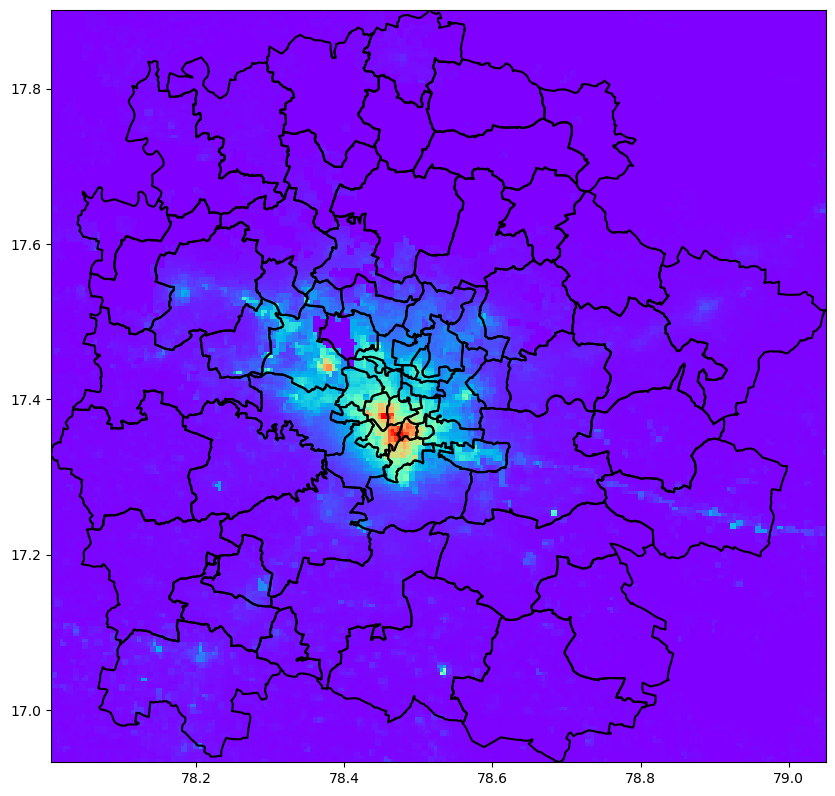

<open DatasetReader name='C:/Users/rishi/ml_projects/climate/Intermediate outputs/NTL cropped and named/20180801-20180831avg_rade9h.tif' mode='r'>


In [11]:
import geopandas as gpd

# Load the shapefile
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Load the GeoTIFF file
vmin = .035  # Minimum value for normalization
vmax = .04  # Maximum value for normalization

# Open the GeoTIFF file
tiff_file = r'C:\Users\rishi\ml_projects\climate\Intermediate outputs\NTL cropped and named\20180801-20180831avg_rade9h.tif'
with rasterio.open(tiff_file) as dataset:
    # Create a normalization instance
    #norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    # Display the image with geospatial context
    fig, ax = plt.subplots(figsize=(10, 10))
    show(dataset, ax=ax, cmap='rainbow')
    # plt.title('HCHO data July 2023')
    
    # # Add a colorbar with the same normalization
    # plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    # plt.xlabel('Longitude')
    # plt.ylabel('Latitude')
    # # Plot the boundary of the GeoDataFrame
    gdf.boundary.plot(ax=ax, edgecolor='black')
    
    plt.show()
    print(dataset)

In [9]:
with rasterio.open(tiff_file) as dataset:
    # Print metadata
    print(dataset.meta)
    num_bands = dataset.count
    print(f"The GeoTIFF file has {num_bands} band(s).")
    # Get the spatial extent (bounding box)
    print("Bounds:", dataset.bounds)
    
    # Read the data as a numpy array (e.g., first band)
    data = dataset.read(1)
    print("Data shape:", data.shape)
    print(data)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 251, 'height': 233, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0041659764940239295, 0.0, 78.00405826,
       0.0, -0.004158212660944214, 17.90150706)}
The GeoTIFF file has 1 band(s).
Bounds: BoundingBox(left=78.00405826, bottom=16.93264351, right=79.04971836, top=17.90150706)
Data shape: (233, 251)
[[14 14 14 ... 14 14 14]
 [13 13 13 ... 14 14 14]
 [13 13 14 ... 14 14 15]
 ...
 [17 17 17 ... 14 14 16]
 [17 17 17 ... 14 14 15]
 [17 17 17 ... 14 14 15]]
